Dataset berhasil dimuat: (10000, 8)

PROSES TRAINING DAN TUNING SEDANG BERJALAN...
>> Melatih KNN (Mencari K terbaik)...
   KNN Terbaik: {'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}

>> Melatih Random Forest...
   RF Terbaik: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

HASIL EVALUASI AKHIR

MODEL: KNN
--------------------
              precision    recall  f1-score   support

      Lewati       0.83      0.87      0.85      1494
      Tonton       0.55      0.46      0.50       506

    accuracy                           0.77      2000
   macro avg       0.69      0.67      0.67      2000
weighted avg       0.76      0.77      0.76      2000


MODEL: Random Forest
--------------------
              precision    recall  f1-score   support

      Lewati       0.87      0.93      0.90      1494
      Tonton       0.74      0.60      0.66       506

    accuracy                           0.85      2000
   macro a

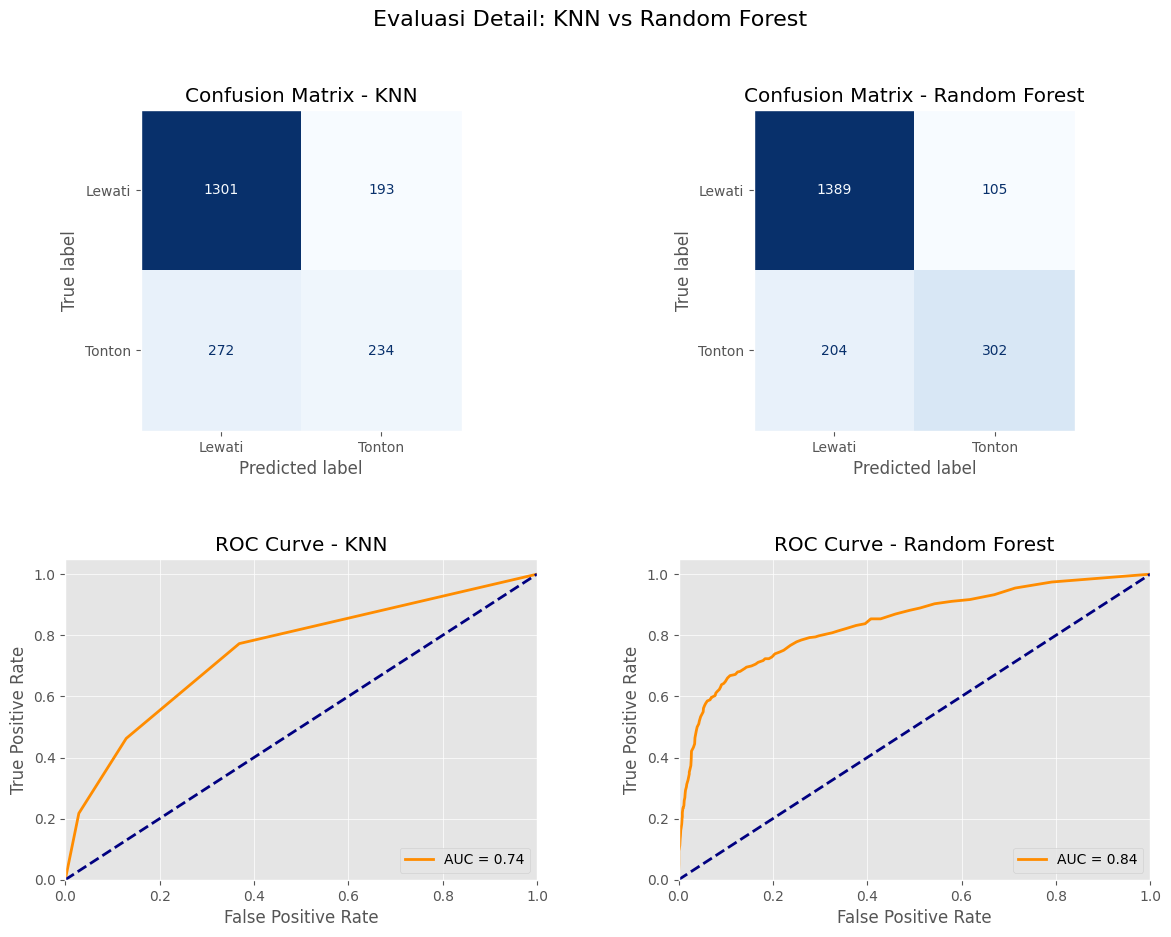

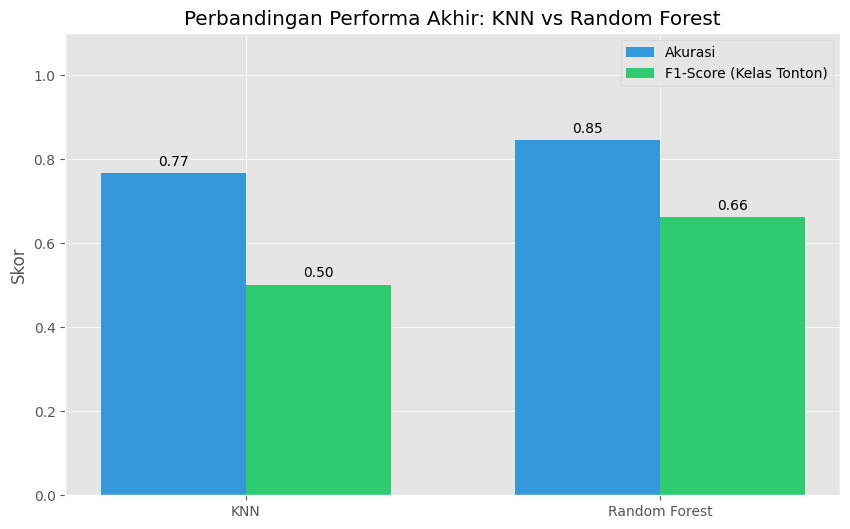

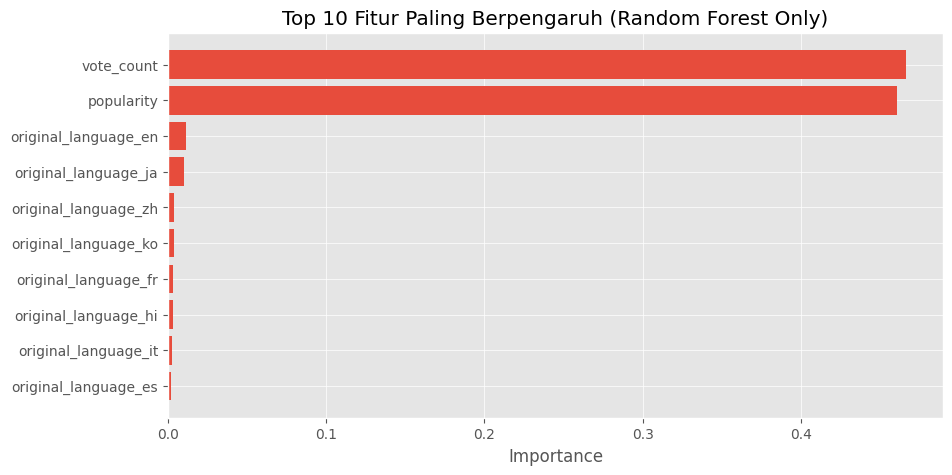

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, auc, 
                             accuracy_score, f1_score)

# Mengatur gaya plot agar rapi tanpa seaborn
plt.style.use('ggplot')

def main():
    # --- 1. MEMUAT DATA ---
    try:
        df = pd.read_csv('Latest 2025 movies Datasets.csv')
        print(f"Dataset berhasil dimuat: {df.shape}")
    except FileNotFoundError:
        print("Error: File csv tidak ditemukan. Pastikan nama file sesuai.")
        return

    # --- 2. PREPARASI DATA ---
    # Target: Rating > 7.0 dianggap "Layak Tonton" (1)
    df['is_watchable'] = (df['vote_average'] > 7.0).astype(int)
    
    # Fitur yang digunakan
    X = df[['popularity', 'vote_count', 'original_language']]
    y = df['is_watchable']

    # Split Data (80% Train, 20% Test)
    # Stratify=y memastikan proporsi kelas seimbang di train dan test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # --- 3. PIPELINE PREPROCESSING ---
    # Pipeline ini akan menangani data kosong dan scaling secara otomatis
    numeric_features = ['popularity', 'vote_count']
    categorical_features = ['original_language']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()) # Scaling wajib untuk KNN
            ]), numeric_features),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features)
        ])

    # --- 4. HYPERPARAMETER TUNING (Grid Search) ---
    print("\n" + "="*60)
    print("PROSES TRAINING DAN TUNING SEDANG BERJALAN...")
    print("="*60)

    # --- A. TUNING KNN ---
    print(">> Melatih KNN (Mencari K terbaik)...")
    knn_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ])
    
    # Mencari kombinasi parameter terbaik
    knn_params = {
        'classifier__n_neighbors': [3, 5, 7, 11],
        'classifier__weights': ['uniform', 'distance']
    }
    
    grid_knn = GridSearchCV(knn_pipeline, knn_params, cv=3, scoring='f1', n_jobs=-1)
    grid_knn.fit(X_train, y_train)
    print(f"   KNN Terbaik: {grid_knn.best_params_}")

    # --- B. TUNING RANDOM FOREST ---
    print("\n>> Melatih Random Forest...")
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
    
    rf_params = {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5]
    }
    
    grid_rf = GridSearchCV(rf_pipeline, rf_params, cv=3, scoring='f1', n_jobs=-1)
    grid_rf.fit(X_train, y_train)
    print(f"   RF Terbaik: {grid_rf.best_params_}")

    # --- 5. EVALUASI DAN VISUALISASI ---
    
    best_models = {
        'KNN': grid_knn.best_estimator_,
        'Random Forest': grid_rf.best_estimator_
    }

    # Canvas 1: Matriks Evaluasi (Confusion Matrix & ROC)
    fig1, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig1.suptitle('Evaluasi Detail: KNN vs Random Forest', fontsize=16)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    results_summary = {'Model': [], 'Accuracy': [], 'F1-Score': []}

    print("\n" + "="*60)
    print("HASIL EVALUASI AKHIR")
    print("="*60)

    for i, (name, model) in enumerate(best_models.items()):
        # Prediksi ke data test
        y_pred = model.predict(X_test)
        
        # Simpan skor untuk perbandingan nanti
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results_summary['Model'].append(name)
        results_summary['Accuracy'].append(acc)
        results_summary['F1-Score'].append(f1)

        # Print Laporan Teks
        print(f"\nMODEL: {name}")
        print("-" * 20)
        print(classification_report(y_test, y_pred, target_names=['Lewati', 'Tonton']))
        
        # Plot 1: Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Lewati', 'Tonton'])
        disp.plot(cmap='Blues', ax=axes[0, i], values_format='d', colorbar=False)
        axes[0, i].set_title(f'Confusion Matrix - {name}')
        axes[0, i].grid(False)

        # Plot 2: ROC Curve
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        axes[1, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
        axes[1, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('False Positive Rate')
        axes[1, i].set_ylabel('True Positive Rate')
        axes[1, i].set_title(f'ROC Curve - {name}')
        axes[1, i].legend(loc="lower right")

    # --- 6. PERBANDINGAN FINAL (BAR CHART) ---
    # Ini memastikan KNN muncul berdampingan dengan RF di akhir
    
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    x = np.arange(len(results_summary['Model']))
    width = 0.35
    
    rects1 = ax2.bar(x - width/2, results_summary['Accuracy'], width, label='Akurasi', color='#3498db')
    rects2 = ax2.bar(x + width/2, results_summary['F1-Score'], width, label='F1-Score (Kelas Tonton)', color='#2ecc71')

    ax2.set_ylabel('Skor')
    ax2.set_title('Perbandingan Performa Akhir: KNN vs Random Forest')
    ax2.set_xticks(x)
    ax2.set_xticklabels(results_summary['Model'])
    ax2.set_ylim([0, 1.1])
    ax2.legend()
    
    # Menambah label nilai di atas batang
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax2.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    # --- 7. FEATURE IMPORTANCE (Hanya RF) ---
    # Kita jelaskan kenapa hanya RF yang punya ini
    print("\n" + "="*60)
    print("ANALISIS FITUR TERPENTING (Khusus Random Forest)")
    print("(Catatan: KNN tidak memiliki fitur ini karena berbasis jarak)")
    print("="*60)
    
    rf_model = grid_rf.best_estimator_.named_steps['classifier']
    preprocessor_step = grid_rf.best_estimator_.named_steps['preprocessor']
    ohe_features = preprocessor_step.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
    all_features = numeric_features + list(ohe_features)
    
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    
    plt.figure(figsize=(10, 5))
    plt.title("Top 10 Fitur Paling Berpengaruh (Random Forest Only)")
    plt.barh(range(len(indices)), importances[indices], color='#e74c3c', align='center')
    plt.yticks(range(len(indices)), [all_features[i] for i in indices])
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    
    print("Menampilkan semua grafik evaluasi...")
    plt.show()

if __name__ == "__main__":
    main()